<a href="https://www.kaggle.com/code/jhtkoo0426/london-housing-price-analysis-1995-2019?scriptVersionId=149857376" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
This notebook aims to uncover and analysis trends in housing prices for all London boroughs.

We will be using the following datasets:
1. [Housing in London](https://www.kaggle.com/datasets/justinas/housing-in-london), with data from 1995-2020

# Loading packages

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import jedi

# Supressing Panda's scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Building the required dataset for analysis
The Housing in London dataset consists of 2 sub datasets:
- The **monthly variables** sub-dataset provides *monthly/yearly average housing prices* for every London borough.
- The **yearly variables** sub-dataset provides *annual median/mean job salaries* for every London borough.

In [2]:
# Load the Housing in London MONTHLY dataset
housing_data = pd.read_csv("/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv")
housing_data.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.00,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.00,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.00,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.00,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.00,NaN,1


In [3]:
# Load the Housing in London YEARLY dataset
salaries_data = pd.read_csv("/kaggle/input/housing-in-london/housing_in_london_yearly_variables.csv")
salaries_data.head()

,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.00,NaN,48922,0,6581.00,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.00,NaN,23620,3,162444.00,NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,19568.00,NaN,23128,8,313469.00,NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,18621.00,NaN,21386,18,217458.00,NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,18532.00,NaN,20911,6,260317.00,NaN,NaN,NaN,1


## Combining housing and salaries datasets
### 1. Remove non-borough entries
We will filter out all values in the `area` column in both datasets that are not London boroughs.
> The London boroughs are the 32 local authority districts that together with the City of London make up the administrative area of Greater London, England; each is governed by a London borough council. (Source: https://en.wikipedia.org/wiki/London_boroughs)

In [4]:
housing_areas = housing_data['area']
salaries_areas = salaries_data['area']
print("Number of unique areas: " + str(len(set(housing_areas))))
print("Number of unique areas: " + str(len(set(salaries_areas))))

Number of unique areas: 45
Number of unique areas: 51


In this analysis, we are only interested in London boroughs. The remaining areas are discarded from the dataset.

In [5]:
boroughs = {'barking and dagenham', 'barnet', 'bexley', 'brent', 'bromley', 'camden', 'city of london', 'croydon', 'ealing', 'enfield', 'greenwich', 'hackney', 'hammersmith and fulham', 'haringey', 'harrow', 'havering', 'hillingdon', 'hounslow', 'islington', 'kensington and chelsea', 'kingston upon thames', 'lambeth', 'lewisham', 'merton', 'newham', 'redbridge', 'richmond upon thames', 'southwark', 'sutton', 'tower hamlets', 'waltham forest', 'wandsworth', 'westminster'}

In [6]:
# Remove all non-borough entries
housing_data = housing_data[housing_data['area'].isin(boroughs)]
salaries_data = salaries_data[salaries_data['area'].isin(boroughs)]

In [7]:
housing_data.shape, salaries_data.shape

((9936, 7), (693, 12))

We notice that there are a different number of entries in both datasets. Apart from the fact that the `monthly` dataset consists of 12x more entries, there are also different ranges of dates provided in the datasets.

In [8]:
print(f"Housing dataset - Start: {min(housing_data['date'])} | End: {max(housing_data['date'])}")
print(f"Salaries dataset - Start: {min(salaries_data['date'])} | End: {max(salaries_data['date'])}")

Housing dataset - Start: 1995-01-01 | End: 2020-01-01
Salaries dataset - Start: 1999-12-01 | End: 2019-12-01


Before performing the aggregate function, we first clean the `date` column in both datasets such that they are in a consistent format by casting the column into the `datetime` data type. Additionally, for the `salaries_data` dataset, we retain only the `year` component of the `date` column.

In [9]:
housing_data['date'] = pd.to_datetime(housing_data['date'])
salaries_data['date'] = pd.to_datetime(salaries_data['date']).dt.year    # Keep the year only

Thus, we retain only the common date ranges in both datasets, i.e. from 1999 to 2019. Conveniently, only the `housing_data` dataset needs to be truncated.

In [10]:
housing_data = housing_data[(housing_data['date'].dt.year >= 1999) & (housing_data['date'].dt.year <= 2019)].reset_index()
housing_data

,index,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,48,1999-01-01,city of london,149143,E09000001,41.00,NaN,1
1,49,1999-02-01,city of london,164545,E09000001,31.00,NaN,1
2,50,1999-03-01,city of london,174586,E09000001,53.00,NaN,1
3,51,1999-04-01,city of london,191157,E09000001,28.00,NaN,1
4,52,1999-05-01,city of london,191081,E09000001,35.00,NaN,1
...,...,...,...,...,...,...,...,...
8311,9932,2019-08-01,westminster,914870,E09000033,156.00,7069.00,1
8312,9933,2019-09-01,westminster,925955,E09000033,169.00,6384.00,1
8313,9934,2019-10-01,westminster,927864,E09000033,168.00,7208.00,1
8314,9935,2019-11-01,westminster,955615,E09000033,150.00,6843.00,1


### 2. Aggregate housing prices by year
Since the dataset lists average housing prices and the number of houses sold per month, we aggregate the total amounts spent on house transactions for each borough per year.

In [11]:
housing_data['total_price'] = housing_data['average_price'] * housing_data['houses_sold']

In [12]:
housing_data = housing_data.groupby([housing_data['date'].dt.year, housing_data['area']])
housing_data = housing_data.agg({'average_price': 'mean', 'houses_sold': 'sum'})

In [13]:
housing_data = housing_data.reset_index()
housing_data = housing_data.rename(columns={'date': 'year'})
housing_data.head()

,year,area,average_price,houses_sold
0,1999,barking and dagenham,65320.83,2686.00
1,1999,barnet,136004.42,7487.00
2,1999,bexley,86777.67,5060.00
3,1999,brent,112157.42,4618.00
4,1999,bromley,120874.08,7147.00


In [14]:
salaries_data = salaries_data.rename(columns={'date': 'year'})
salaries_data.head()

,code,area,year,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999,33020.00,NaN,48922,0,6581.00,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999,21480.00,NaN,23620,3,162444.00,NaN,NaN,NaN,1
2,E09000003,barnet,1999,19568.00,NaN,23128,8,313469.00,NaN,NaN,NaN,1
3,E09000004,bexley,1999,18621.00,NaN,21386,18,217458.00,NaN,NaN,NaN,1
4,E09000005,brent,1999,18532.00,NaN,20911,6,260317.00,NaN,NaN,NaN,1


### 3. Merge the housing and salaries datasets

In [15]:
complete_data = pd.merge(housing_data, salaries_data, left_on=['area', 'year'], right_on=['area', 'year'])
complete_data

,year,area,average_price,houses_sold,code,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,1999,barking and dagenham,65320.83,2686.00,E09000002,21480.00,NaN,23620,3,162444.00,NaN,NaN,NaN,1
1,1999,barnet,136004.42,7487.00,E09000003,19568.00,NaN,23128,8,313469.00,NaN,NaN,NaN,1
2,1999,bexley,86777.67,5060.00,E09000004,18621.00,NaN,21386,18,217458.00,NaN,NaN,NaN,1
3,1999,brent,112157.42,4618.00,E09000005,18532.00,NaN,20911,6,260317.00,NaN,NaN,NaN,1
4,1999,bromley,120874.08,7147.00,E09000006,16720.00,NaN,21293,13,294902.00,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2019,sutton,372501.08,2237.00,E09000029,32947.00,NaN,37392,NaN,NaN,NaN,NaN,NaN,1
689,2019,tower hamlets,439009.58,2017.00,E09000030,46142.00,NaN,69434,NaN,NaN,NaN,NaN,NaN,1
690,2019,waltham forest,430663.58,2238.00,E09000031,30718.00,NaN,33119,NaN,NaN,NaN,NaN,NaN,1
691,2019,wandsworth,588672.42,3726.00,E09000032,34168.00,NaN,39617,NaN,NaN,NaN,NaN,NaN,1


## Dataset preprocessing
### 1. Feature selection & engineering


In [16]:
# Feature selection - removing irrelevant features
irrelevant_housing_features = ['code', 'recycling_pct', 'area_size', 'borough_flag', 'population_size']
complete_data = complete_data.drop(columns=irrelevant_housing_features, axis=1, errors='ignore')
complete_data

,year,area,average_price,houses_sold,median_salary,life_satisfaction,mean_salary,number_of_jobs,no_of_houses
0,1999,barking and dagenham,65320.83,2686.00,21480.00,NaN,23620,NaN,NaN
1,1999,barnet,136004.42,7487.00,19568.00,NaN,23128,NaN,NaN
2,1999,bexley,86777.67,5060.00,18621.00,NaN,21386,NaN,NaN
3,1999,brent,112157.42,4618.00,18532.00,NaN,20911,NaN,NaN
4,1999,bromley,120874.08,7147.00,16720.00,NaN,21293,NaN,NaN
...,...,...,...,...,...,...,...,...,...
688,2019,sutton,372501.08,2237.00,32947.00,NaN,37392,NaN,NaN
689,2019,tower hamlets,439009.58,2017.00,46142.00,NaN,69434,NaN,NaN
690,2019,waltham forest,430663.58,2238.00,30718.00,NaN,33119,NaN,NaN
691,2019,wandsworth,588672.42,3726.00,34168.00,NaN,39617,NaN,NaN


### 2. Processing NULL values

In [17]:
housing_null = complete_data.isna().mean().sort_values(ascending=False)
housing_null[housing_null > 0]

life_satisfaction   0.63
no_of_houses        0.14
number_of_jobs      0.10
median_salary       0.01
dtype: float64

The above Series display the percentage of NULL values in each column that contains NULL values. We will be treating these columns differently:
1. Since the `life_satisfaction` column of the dataset is predominantly populated with NULL values, we will remove this feature.
2. The NULL values in the remaining columns can be replaced with zero as it is reasonable to do so - some areas may have zero jobs and zero house transactions in specific periods.

In [18]:
complete_data = complete_data.fillna(0)
complete_data

,year,area,average_price,houses_sold,median_salary,life_satisfaction,mean_salary,number_of_jobs,no_of_houses
0,1999,barking and dagenham,65320.83,2686.00,21480.00,0.00,23620,0.00,0.00
1,1999,barnet,136004.42,7487.00,19568.00,0.00,23128,0.00,0.00
2,1999,bexley,86777.67,5060.00,18621.00,0.00,21386,0.00,0.00
3,1999,brent,112157.42,4618.00,18532.00,0.00,20911,0.00,0.00
4,1999,bromley,120874.08,7147.00,16720.00,0.00,21293,0.00,0.00
...,...,...,...,...,...,...,...,...,...
688,2019,sutton,372501.08,2237.00,32947.00,0.00,37392,0.00,0.00
689,2019,tower hamlets,439009.58,2017.00,46142.00,0.00,69434,0.00,0.00
690,2019,waltham forest,430663.58,2238.00,30718.00,0.00,33119,0.00,0.00
691,2019,wandsworth,588672.42,3726.00,34168.00,0.00,39617,0.00,0.00


# Visualizations

In [19]:
def plotHousingPriceTrend(df):
    # Plot housing price trends from 1975 to 2021
    fig, ax = plt.subplots(figsize=(12, 8))

    colormap = plt.cm.gist_ncar
    ax.ticklabel_format(style='plain')
    sns.lineplot(data=df, x='year', y='average_price', hue='area')

    plt.title('Average Price by Area Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Price')
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(boroughs)))))
    plt.legend(title='Area', title_fontsize='15', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

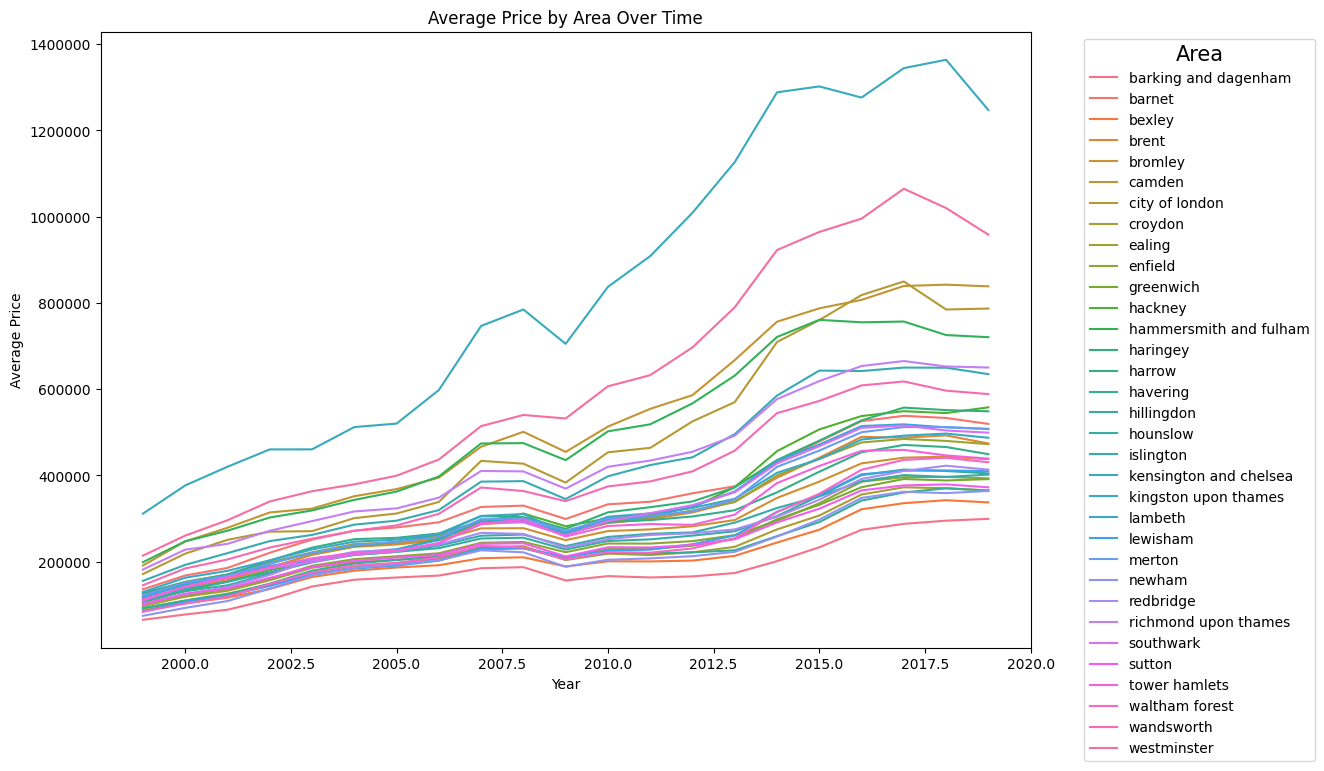

In [20]:
plotHousingPriceTrend(housing_data)

Visualizing variations in housing prices across all London boroughs

In [21]:
# set the filepath and load in a shapefile
fp = "/kaggle/input/london-borough-boundaries/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
borough_map_df = gpd.read_file(fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
borough_map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.12,0.00,F,NaN,NaN,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.44,0.00,F,NaN,NaN,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.49,0.00,F,NaN,NaN,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.54,60.76,F,NaN,NaN,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.43,0.00,F,NaN,NaN,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [22]:
def plotBoroughHousingPricesByYear(housing_dataset, borough_map, year):
    years = list(set(housing_dataset['year']))
     
    # Decapitalize borough name column
    borough_map_df['NAME'] = borough_map_df['NAME'].apply(lambda x: x.lower())
    
    # Prepare housing prices series for plotting
    filtered_housing_dataset = housing_dataset[housing_dataset['year'] == year]
    housing_prices = pd.DataFrame(filtered_housing_dataset[['area', 'average_price']])
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f"Average housing prices by London borough in {year}")
    merged_df = borough_map_df.set_index('NAME').join(housing_prices.set_index('area'))
    merged_df.plot(column='average_price', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    
    for x, y, label, price in zip(merged_df.geometry.centroid.x, merged_df.geometry.centroid.y, merged_df.index, merged_df['average_price']):
        ax.text(x, y, f"{label.capitalize()}:\n£{str(round(price, 2))}", fontsize=6, ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

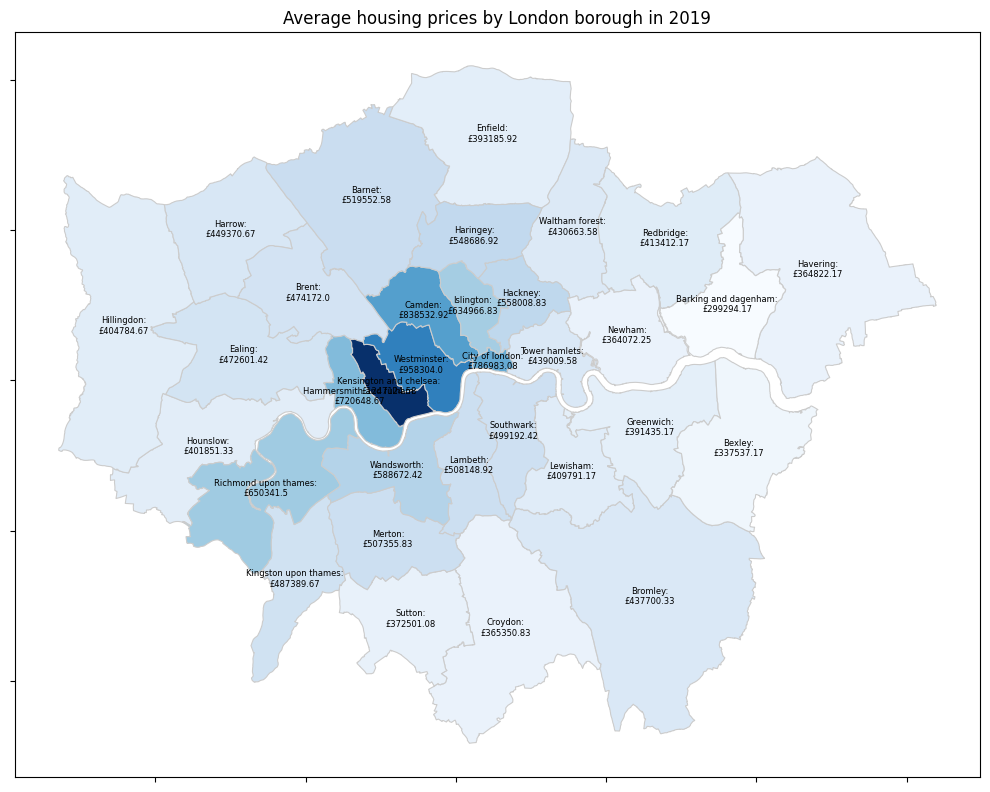

In [23]:
plotBoroughHousingPricesByYear(complete_data, borough_map_df, 2019)

## Conclusions
1. Kensington and Chelsea is consistently the most expensive London borouogh throughout 1995 to 2019, followed by Westminster and Camden.
2. The most expensive London boroughs are all located in Centra and North-West London.